#Cellula Task2: Booking Status Classification

#Developed By: Eng. Waleed Shaban

### Connect to Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import libraries

In [2]:
!pip install scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 67.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [3]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.utils.class_weight import compute_class_weight


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier

warnings.filterwarnings('ignore')
set_config(display='diagram')

### Define Utilities

In [4]:
def compare_features(df:pd.DataFrame, feature_1:str, feature_2:str):
    fig, axs = plt.subplots(2, 1, figsize=(8, 8))
    # Set the title for the entire figure
    fig.suptitle(f'Distribution of {feature_1} Vs {feature_2}')
    sns.histplot(df[feature_1], ax=axs[0])
    sns.histplot(df[feature_2], ax=axs[1])
    # Set the space between sub figures
    plt.subplots_adjust(hspace=0.2)
    plt.show()

##Step 1: Data Overview & Data Preprocessing

### Read & Explore The Data

In [5]:
data_path = '/content/drive/MyDrive/Datasets/first inten project.csv'
df = pd.read_csv(data_path)
df.head(10)

,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,date of reservation,booking status
0,INN00001,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,10/2/2015,Not_Canceled
1,INN00002,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,11/6/2018,Not_Canceled
2,INN00003,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,2/28/2018,Canceled
3,INN00004,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,5/20/2017,Canceled
4,INN00005,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,4/11/2018,Canceled
5,INN00006,1,0,0,2,Meal Plan 2,0,Room_Type 1,346,Offline,0,0,0,100.00,1,9/13/2016,Canceled
6,INN00007,1,1,1,4,Meal Plan 1,0,Room_Type 1,34,Online,0,0,0,107.55,1,10/15/2017,Not_Canceled
7,INN00008,3,0,1,3,Meal Plan 1,0,Room_Type 4,83,Online,0,0,0,105.61,1,12/26/2018,Not_Canceled
8,INN00009,1,1,0,4,Meal Plan 1,0,Room_Type 1,121,Offline,0,0,0,96.90,1,7/6/2018,Not_Canceled
9,INN00010,2,0,0,5,Meal Plan 1,0,Room_Type 4,44,Online,0,0,0,133.44,3,10/18/2018,Not_Canceled


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36285 entries, 0 to 36284
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Booking_ID                36285 non-null  object 
 1   number of adults          36285 non-null  int64  
 2   number of children        36285 non-null  int64  
 3   number of weekend nights  36285 non-null  int64  
 4   number of week nights     36285 non-null  int64  
 5   type of meal              36285 non-null  object 
 6   car parking space         36285 non-null  int64  
 7   room type                 36285 non-null  object 
 8   lead time                 36285 non-null  int64  
 9   market segment type       36285 non-null  object 
 10  repeated                  36285 non-null  int64  
 11  P-C                       36285 non-null  int64  
 12  P-not-C                   36285 non-null  int64  
 13  average price             36285 non-null  float64
 14  specia

### Check Nulls

In [7]:
df.isnull().sum()

,0
Booking_ID,0
number of adults,0
number of children,0
number of weekend nights,0
number of week nights,0
type of meal,0
car parking space,0
room type,0
lead time,0
market segment type,0


### Check Dupplicate

In [8]:
df.duplicated().sum()

0

### Descriptive Statistics

In [9]:
df.describe()

,number of adults,number of children,number of weekend nights,number of week nights,car parking space,lead time,repeated,P-C,P-not-C,average price,special requests
count,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000
mean,1.844839,0.105360,0.810693,2.204602,0.030977,85.239851,0.025630,0.023343,0.153369,103.421636,0.619733
std,0.518813,0.402704,0.870590,1.410946,0.173258,85.938796,0.158032,0.368281,1.753931,35.086469,0.786262
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,1.000000,13.000000,58.000000,540.000000,5.000000


## Step 2: Feature Engineering

In [10]:
def feature_engineering(df):
    df['total_nights'] = df['number of week nights'] + df['number of weekend nights']
    df['average_price_per_night'] = (df['average price '] / df['total_nights']).round(2)
    df['total_guest'] = df['number of adults'] + df['number of children']
    df['average_price_per_night_per_guest'] = (df['average_price_per_night'] / df['total_guest']).round(2)
    return df

In [11]:
add_features = FunctionTransformer(feature_engineering)
df = add_features.fit_transform(df)
df.head()

,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,...,P-C,P-not-C,average price,special requests,date of reservation,booking status,total_nights,average_price_per_night,total_guest,average_price_per_night_per_guest
0,INN00001,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,...,0,0,88.00,0,10/2/2015,Not_Canceled,7,12.57,2,6.28
1,INN00002,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,...,0,0,106.68,1,11/6/2018,Not_Canceled,4,26.67,1,26.67
2,INN00003,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,...,0,0,50.00,0,2/28/2018,Canceled,4,12.50,3,4.17
3,INN00004,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,...,0,0,100.00,1,5/20/2017,Canceled,2,50.00,1,50.00
4,INN00005,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,...,0,0,77.00,0,4/11/2018,Canceled,3,25.67,1,25.67


## Step 3: Check And Handel The Outliers

### Check Data Distribution

In [12]:
num_features = ['number of adults', 'number of children', 'total_guest', 'number of weekend nights',
                'number of week nights', 'lead time', 'average price ', 'car parking space',
                'repeated', 'P-C', 'P-not-C', 'special requests', 'total_nights', 'average_price_per_night',
                'total_guest', 'average_price_per_night_per_guest']

cat_features = ['room type', 'type of meal', 'market segment type']

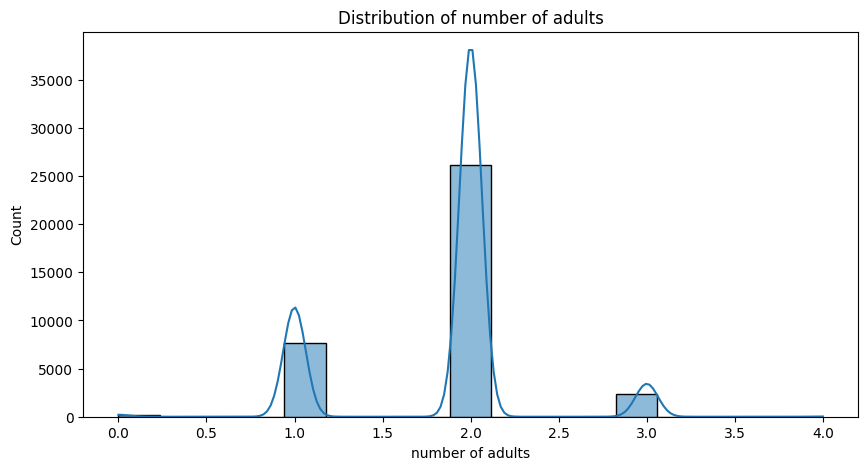

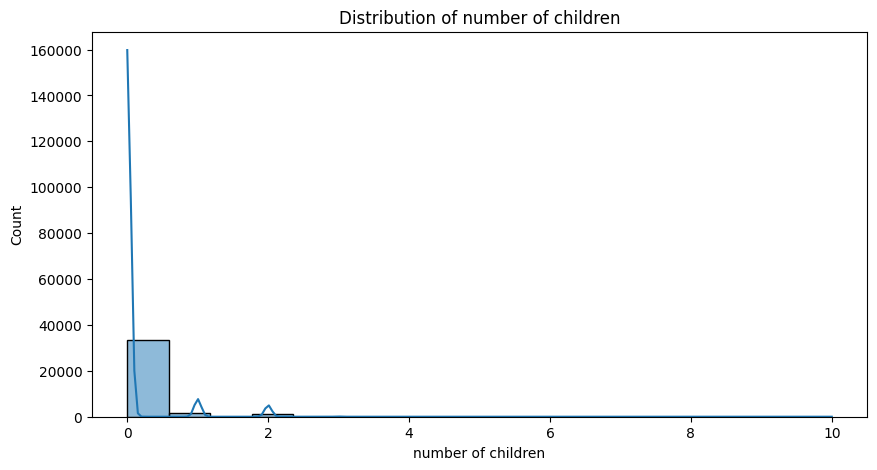

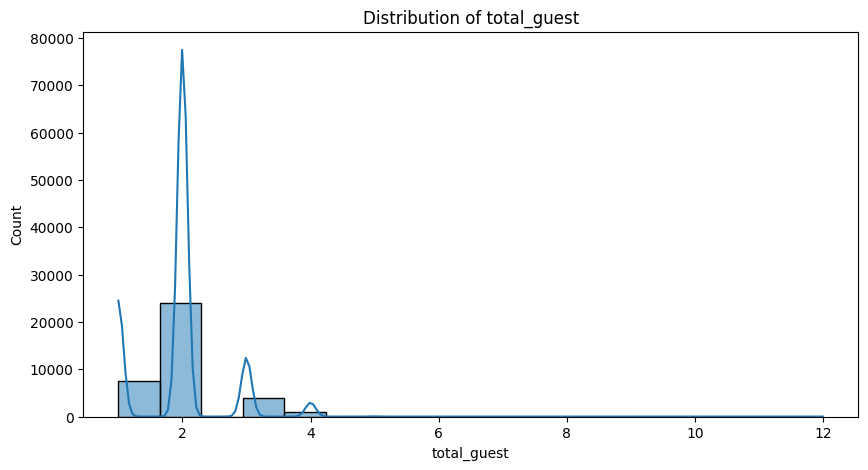

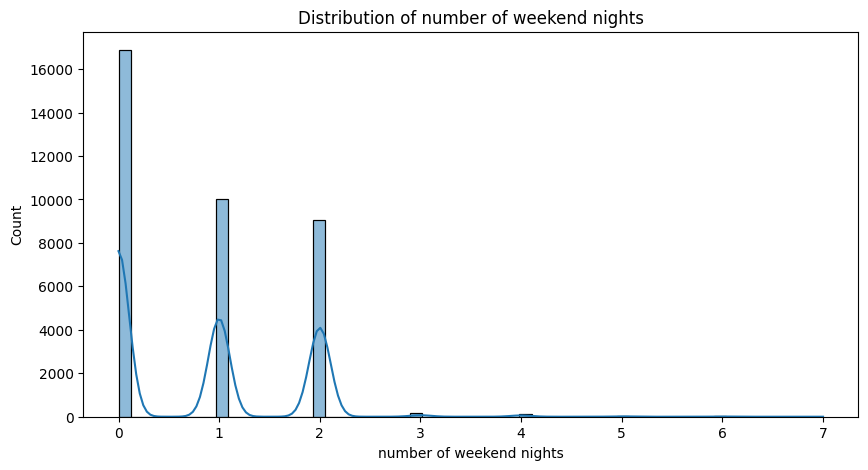

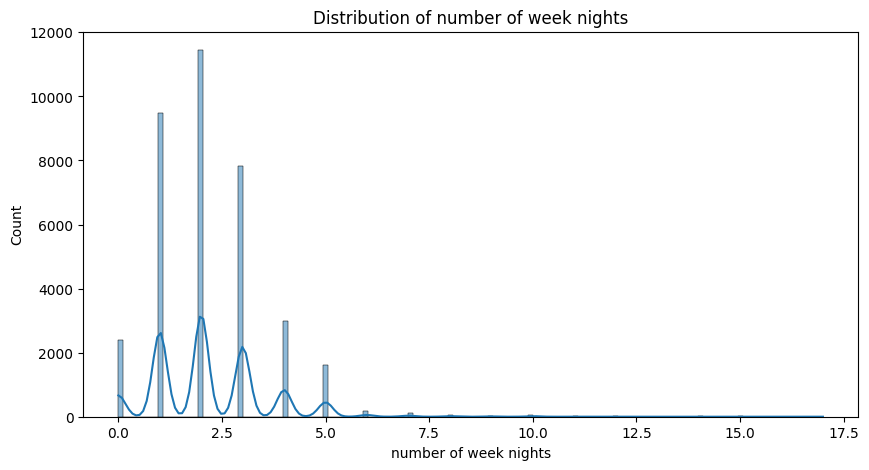

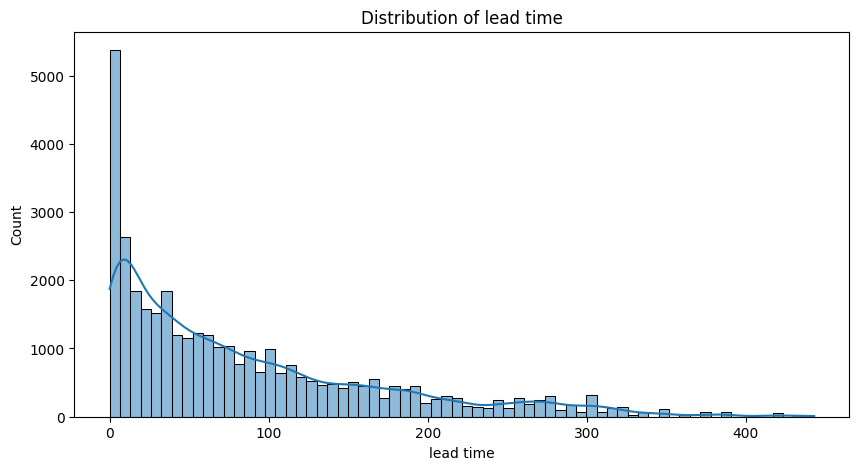

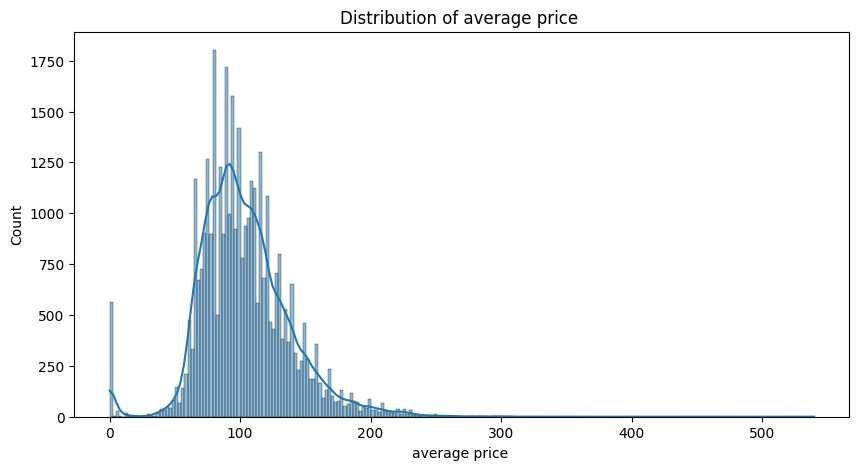

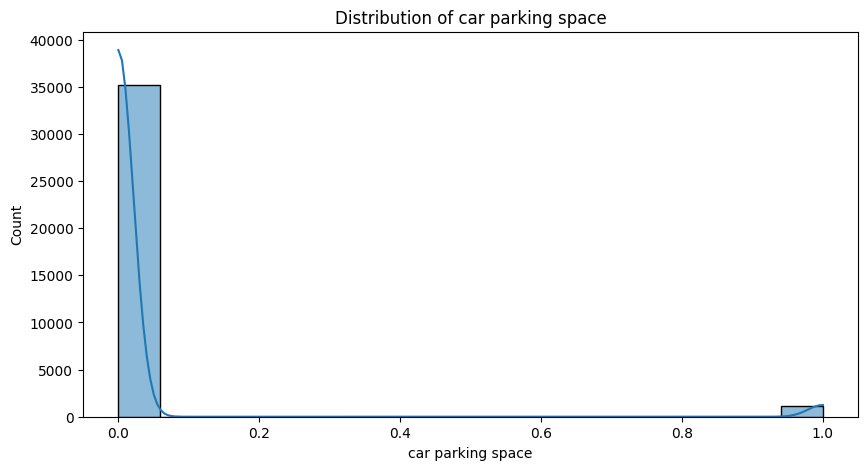

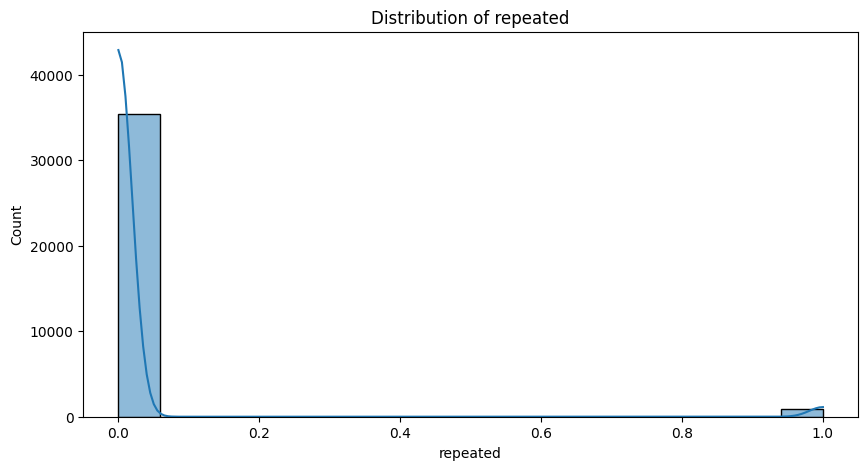

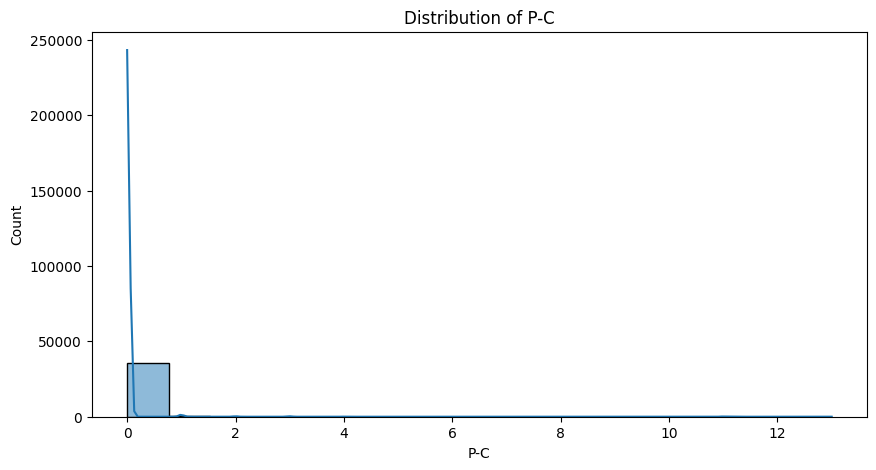

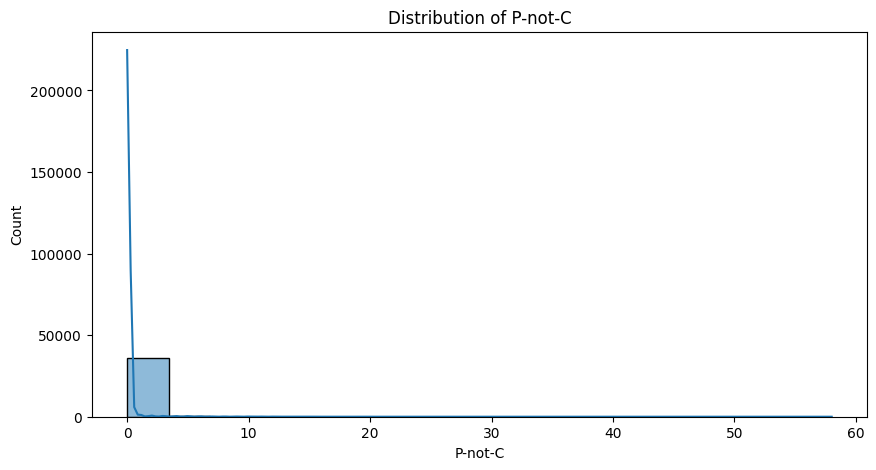

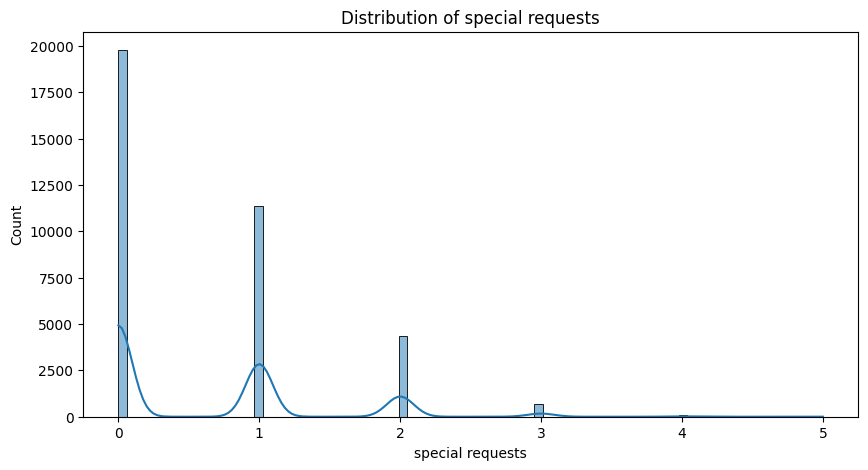

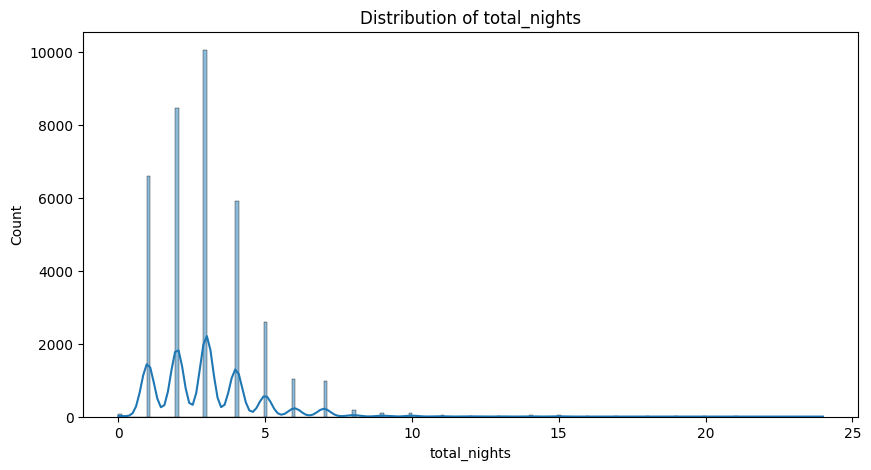

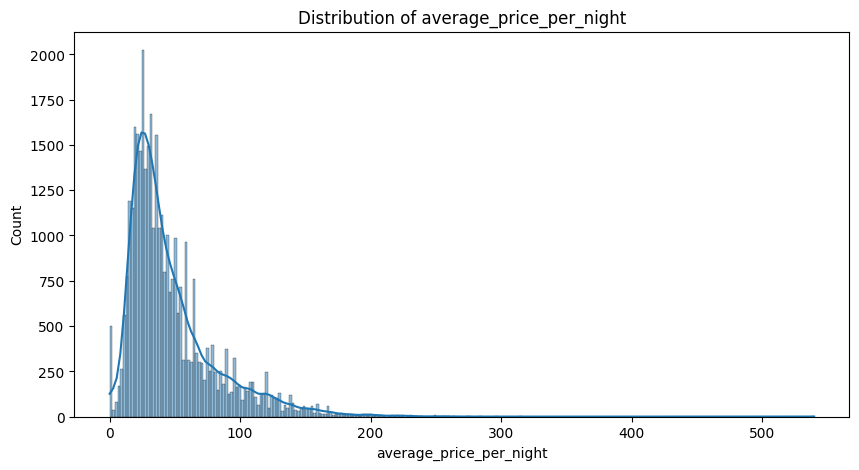

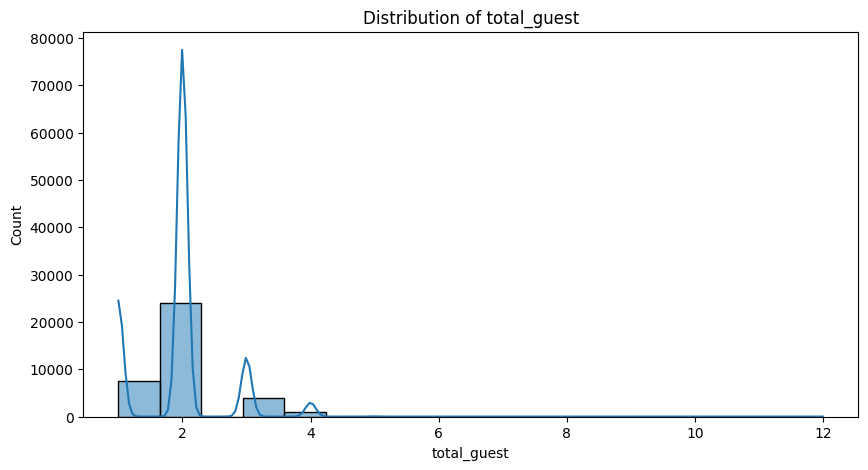

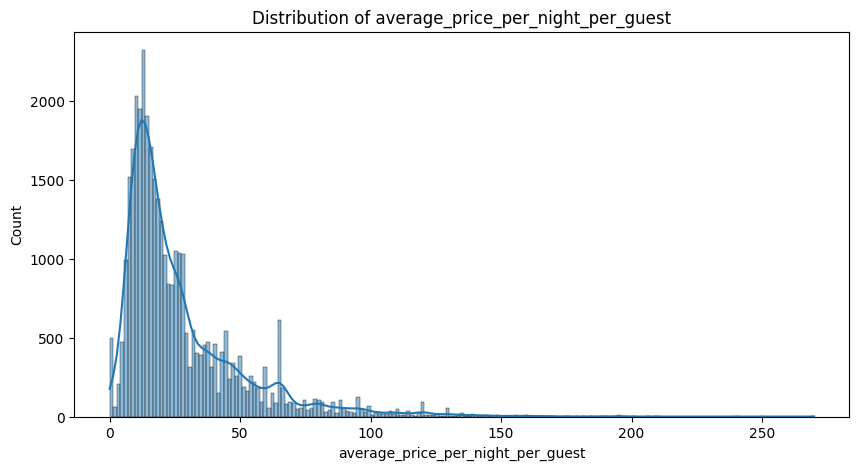

In [13]:
for feature in num_features:
    plt.figure(figsize=(10, 5))
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()
    print()

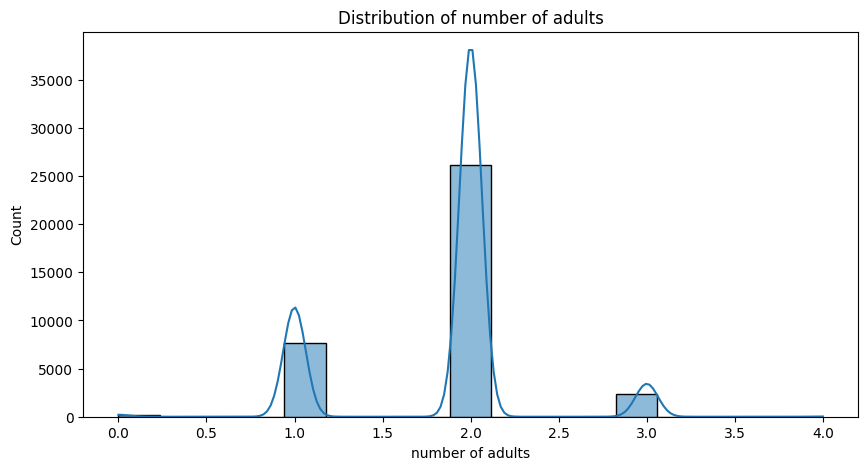

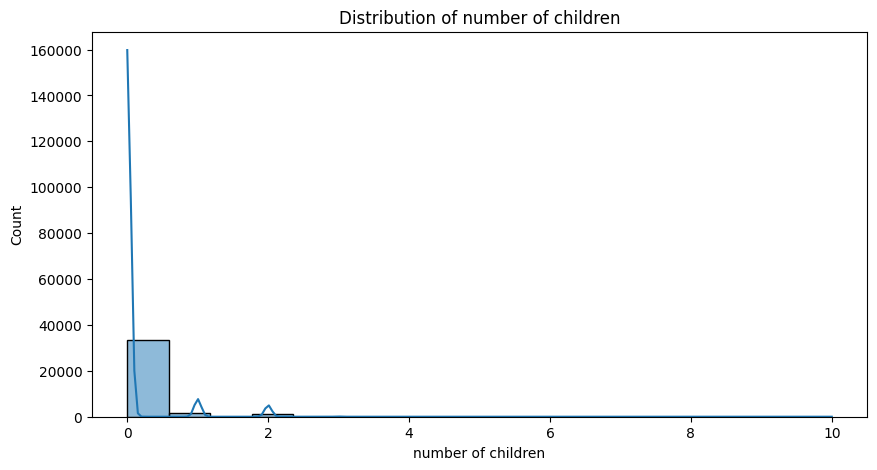

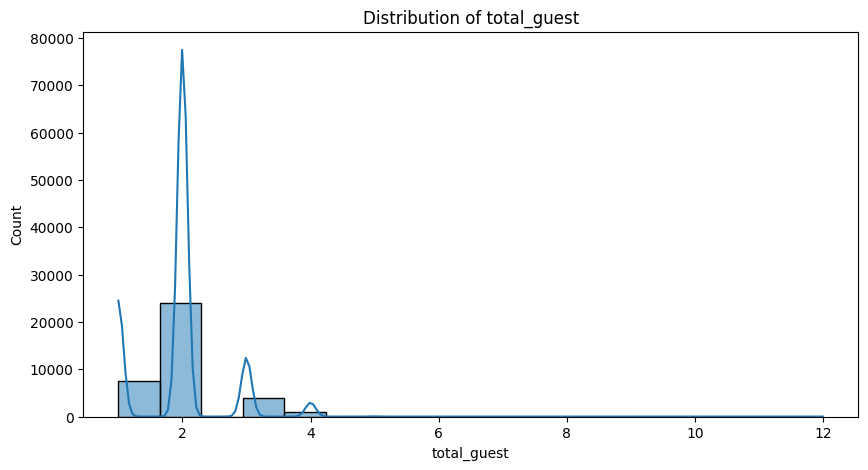

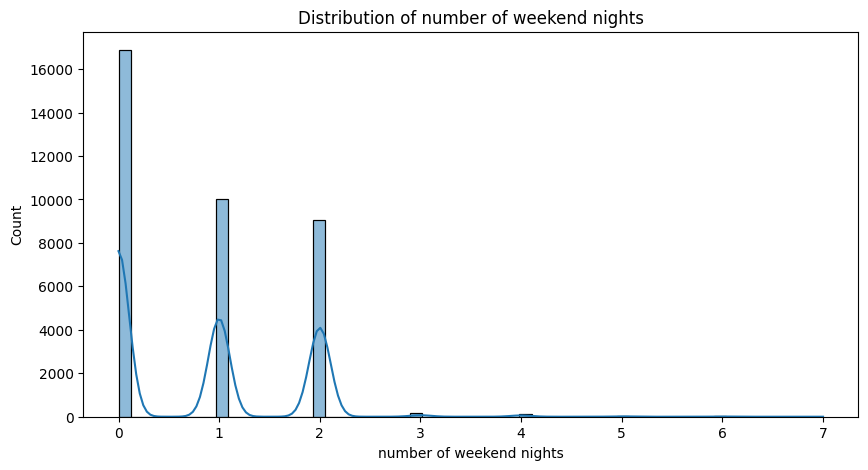

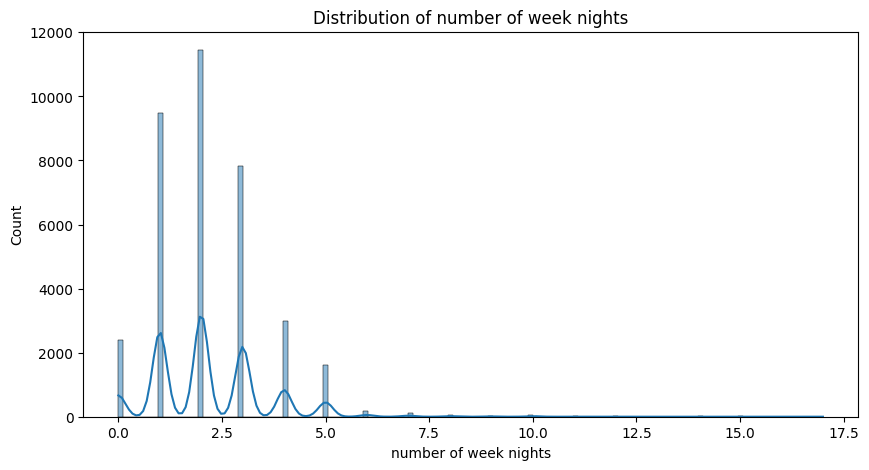

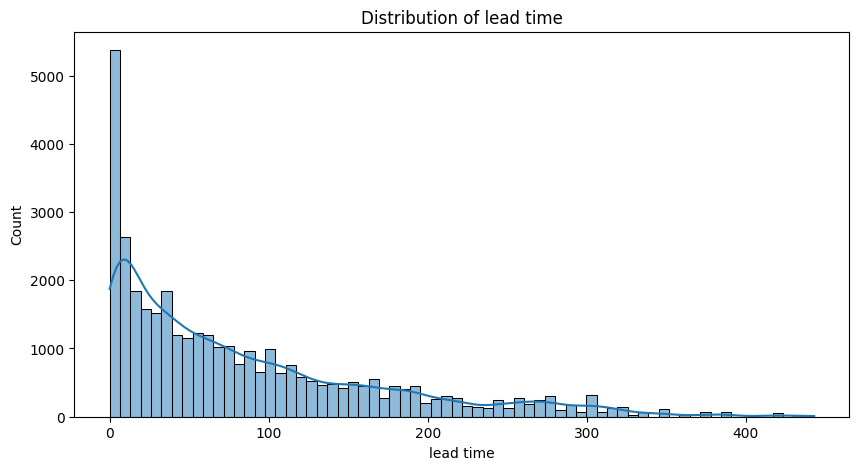

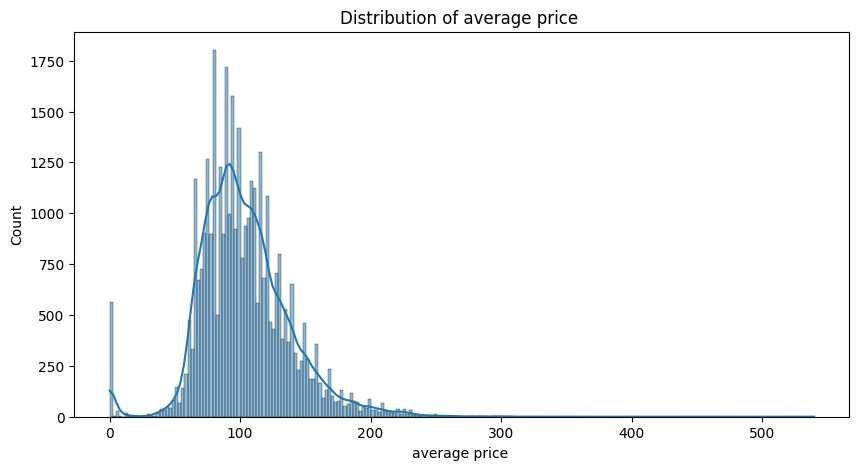

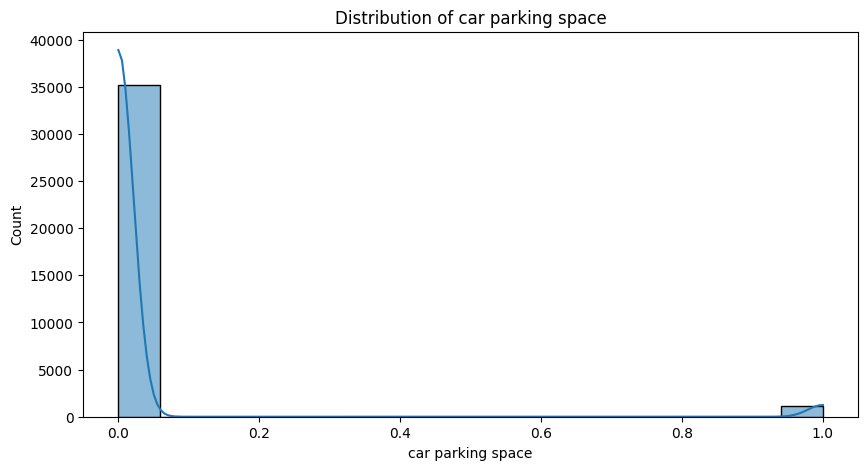

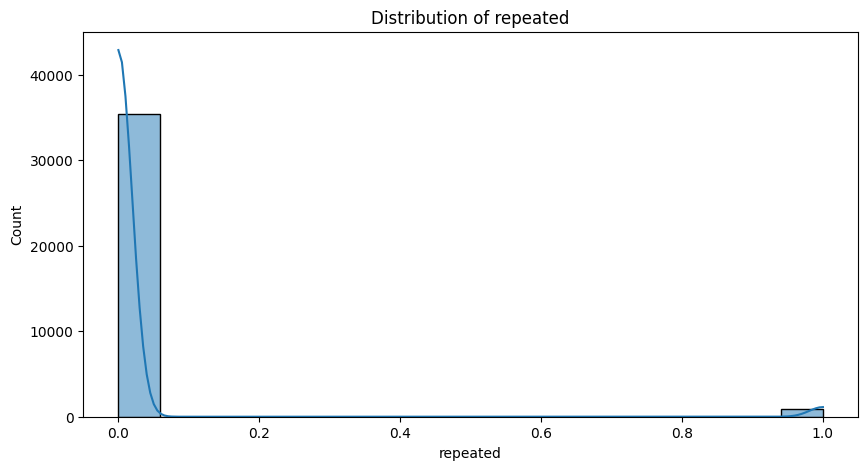

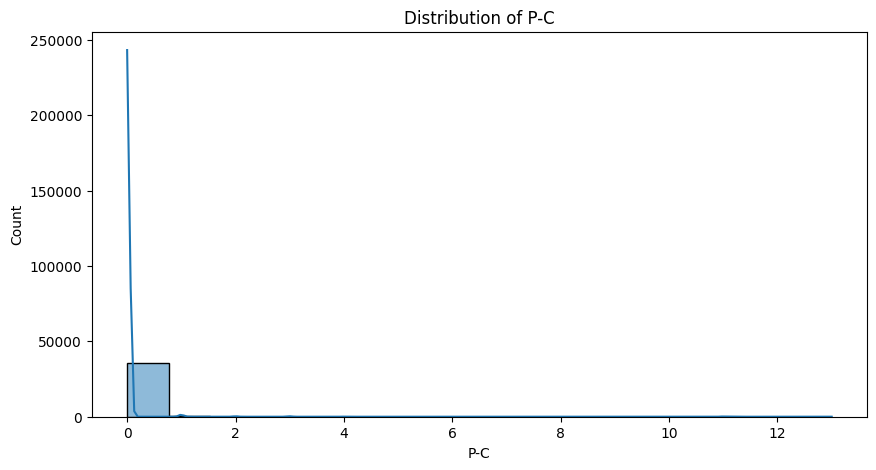

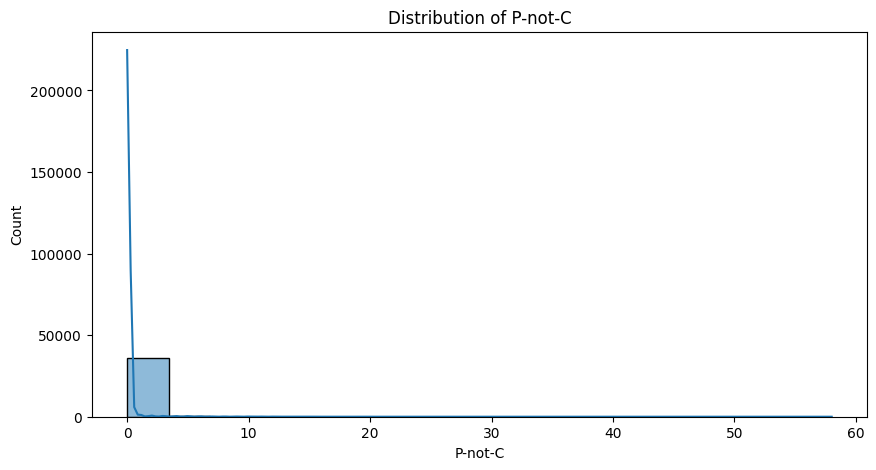

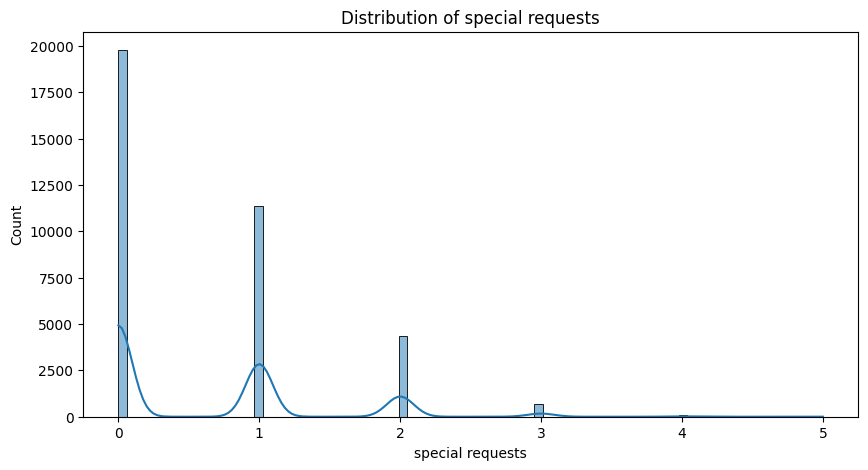

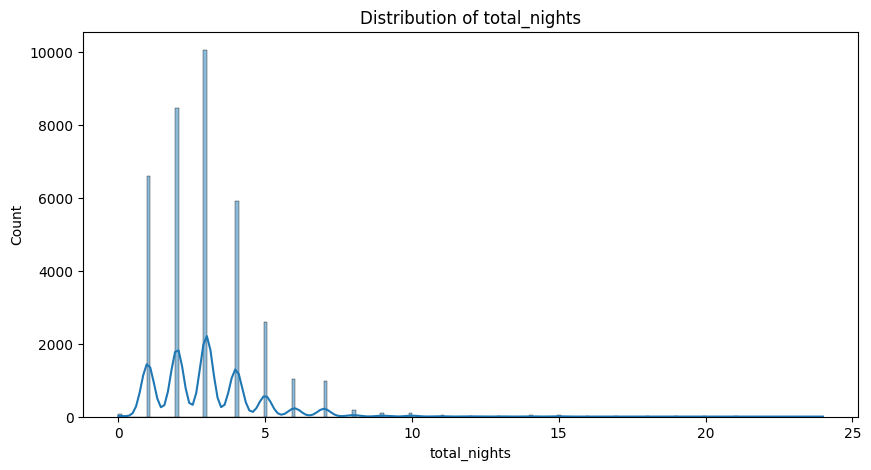

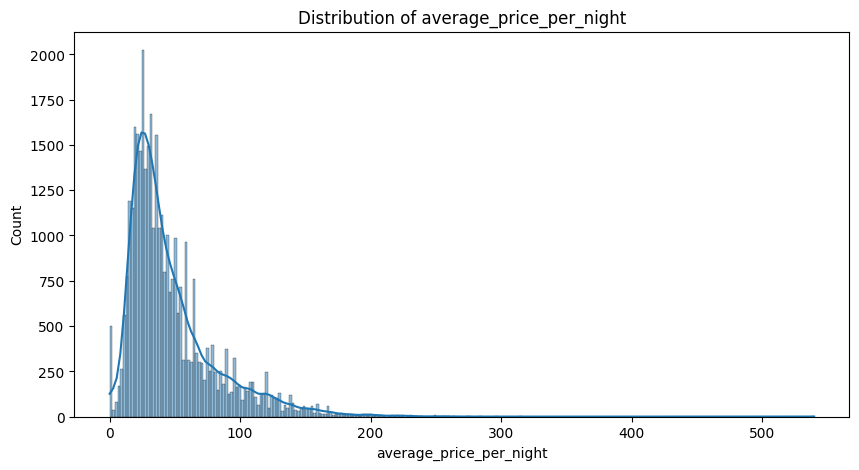

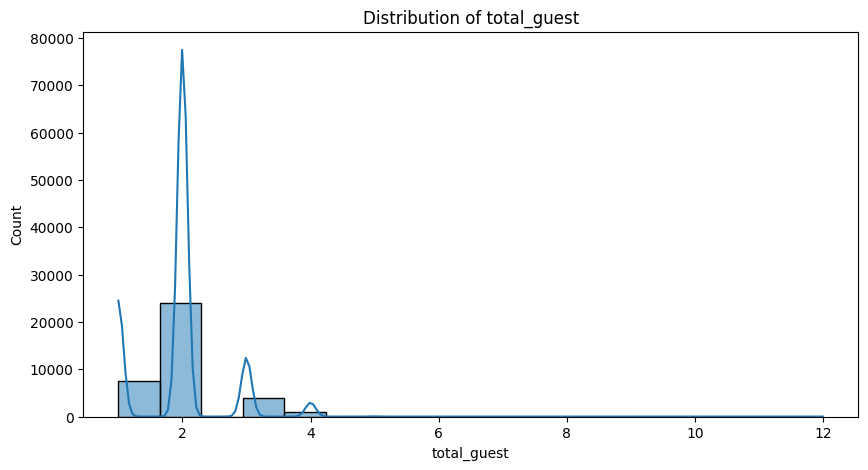

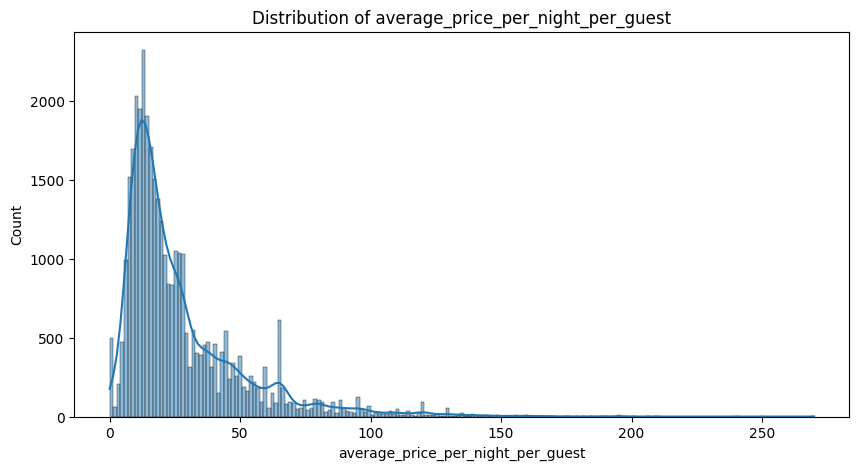

In [14]:
for feature in num_features:
    plt.figure(figsize=(10, 5))
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()
    print()

### Check Outlier

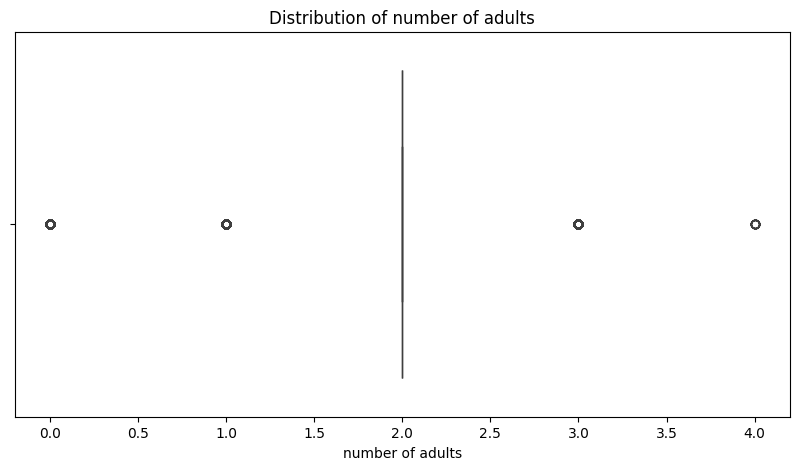

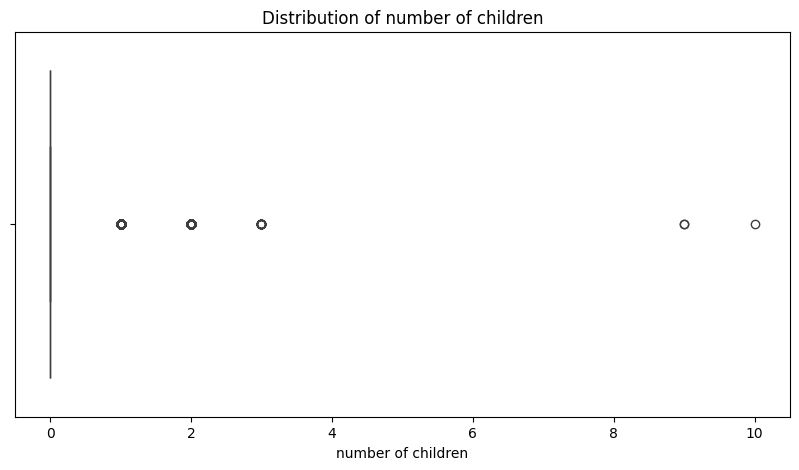

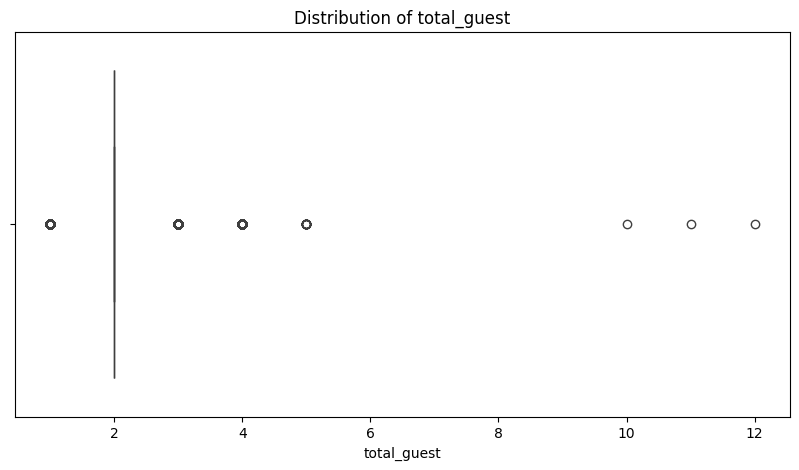

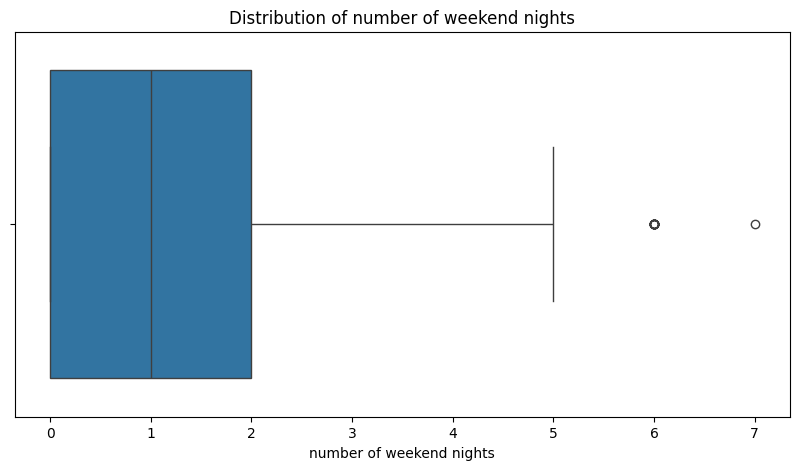

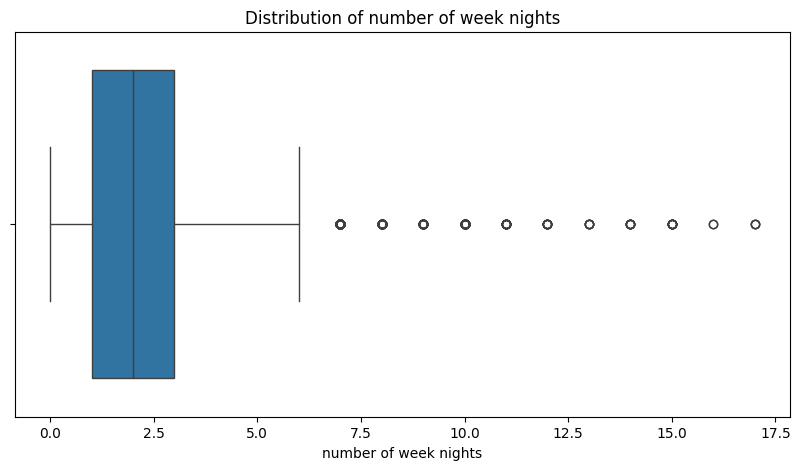

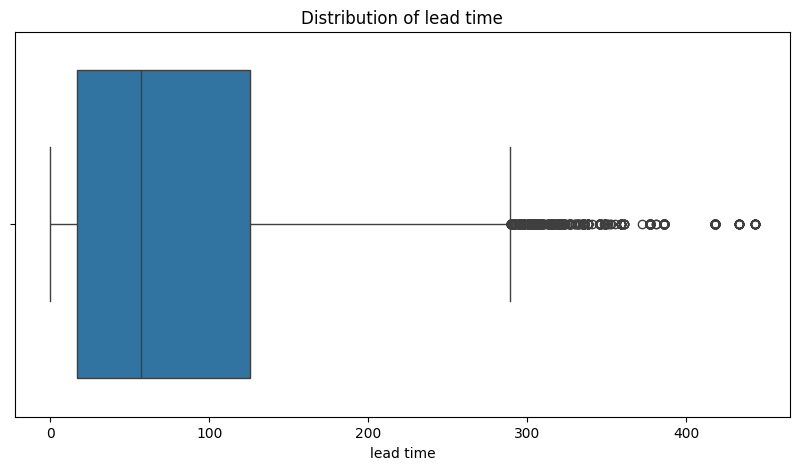

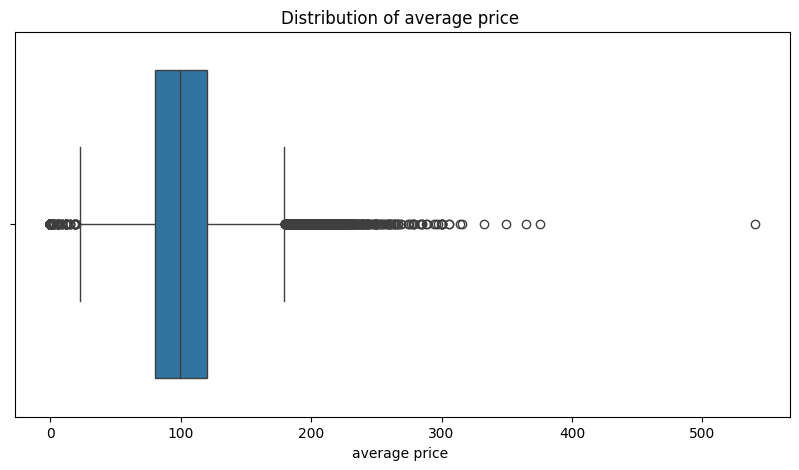

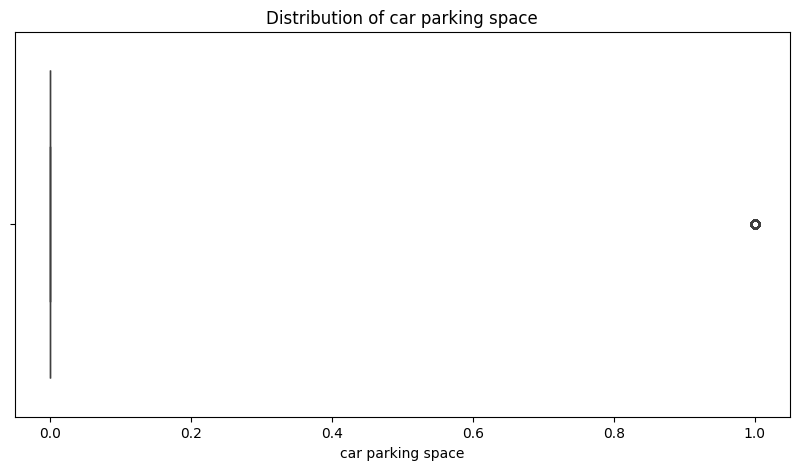

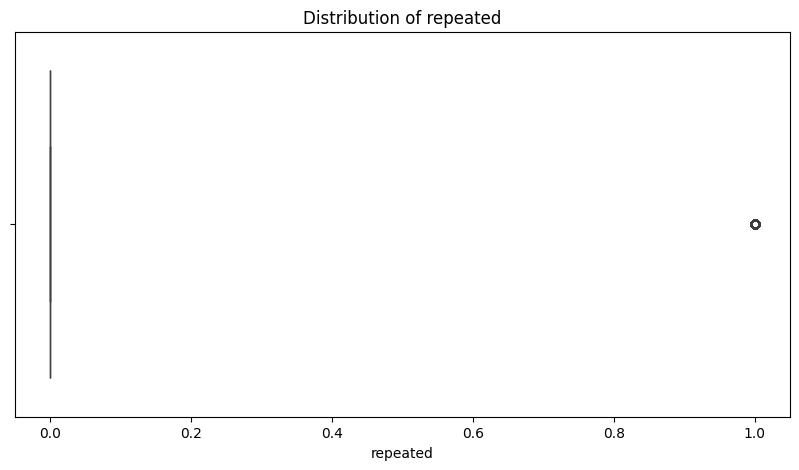

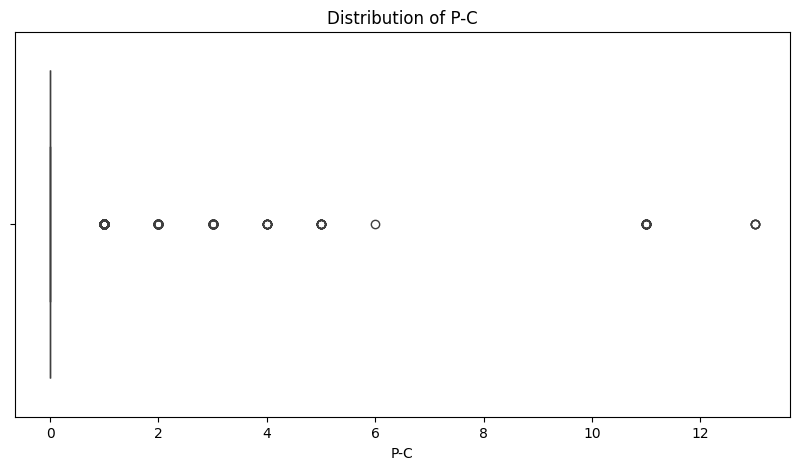

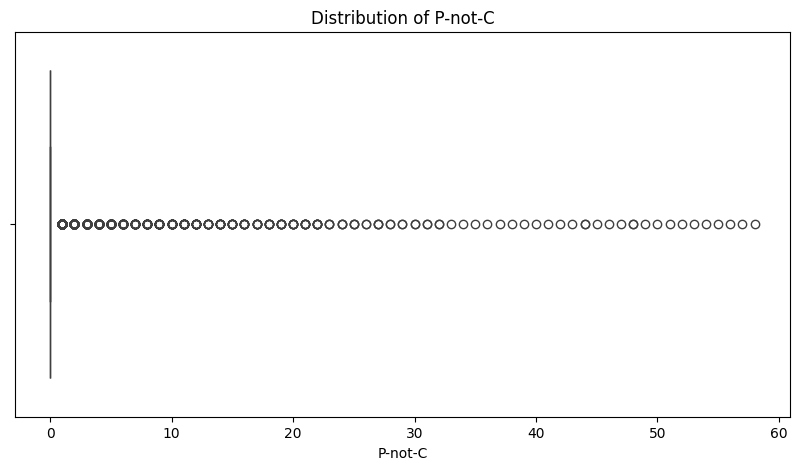

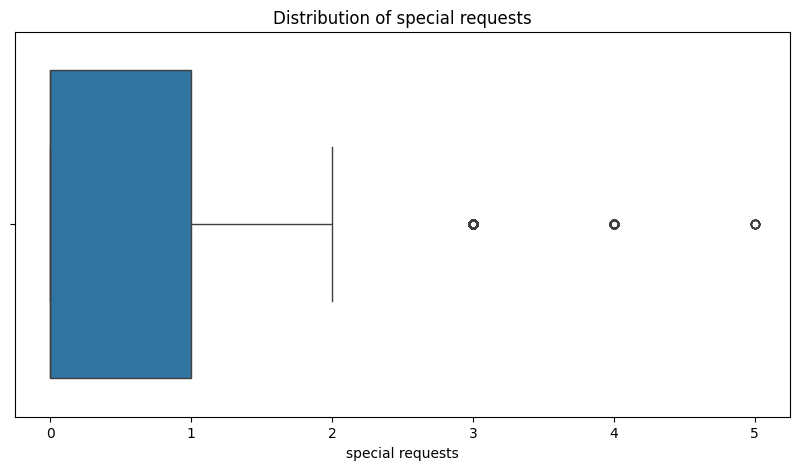

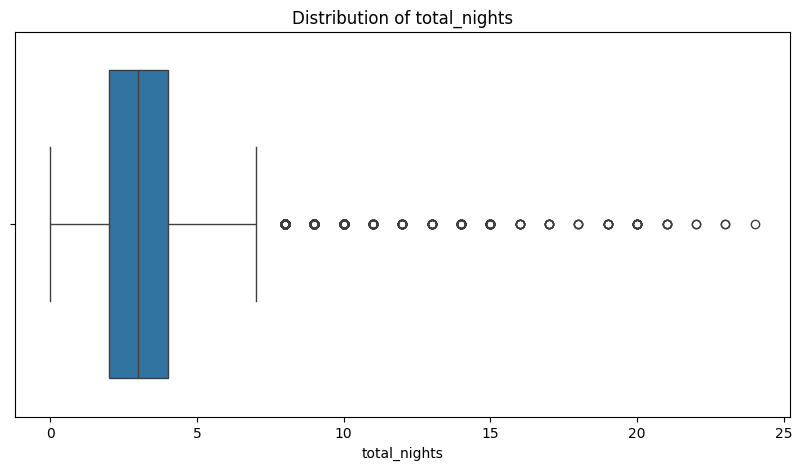

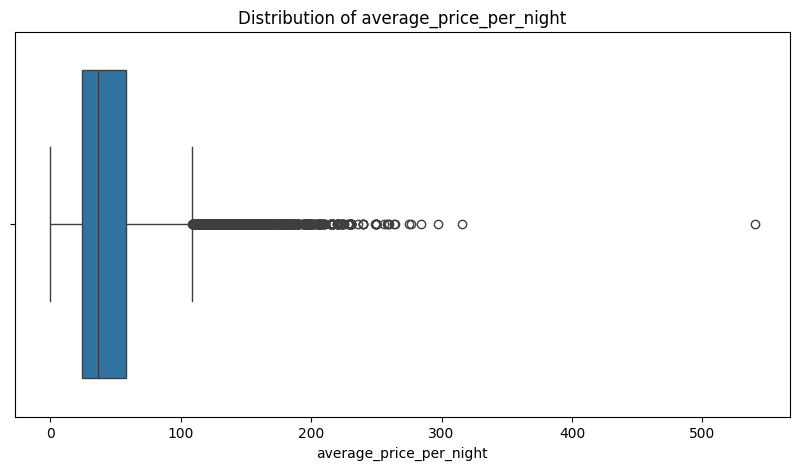

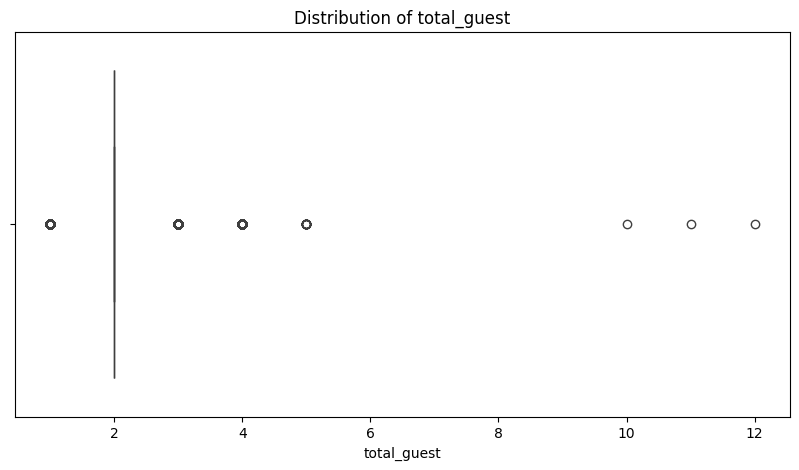

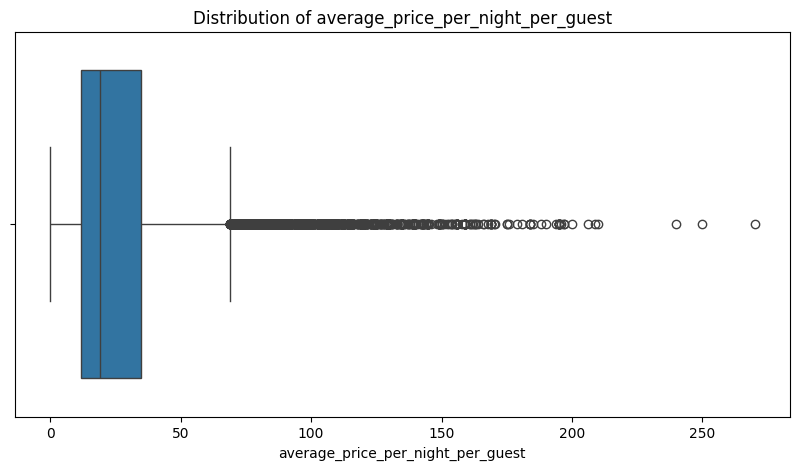

In [15]:
for feature in num_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df[feature])
    plt.title(f'Distribution of {feature}')
    plt.show()
    print()

### Outlier Handling

In [16]:
def outlier_treatment(df:pd.DataFrame, features_name: list)->pd.DataFrame:
    for feature in features_name:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[feature][(df[feature] < lower_bound)] = lower_bound
        df[feature][(df[feature] > upper_bound)] = upper_bound
    return df

In [17]:
outlier_features = ['lead time', 'special requests', 'total_nights', 'average_price_per_night_per_guest']
df = outlier_treatment(df, outlier_features)

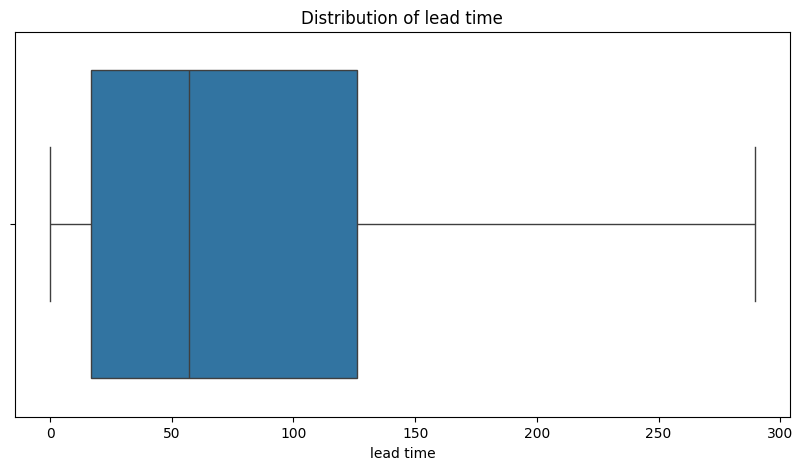

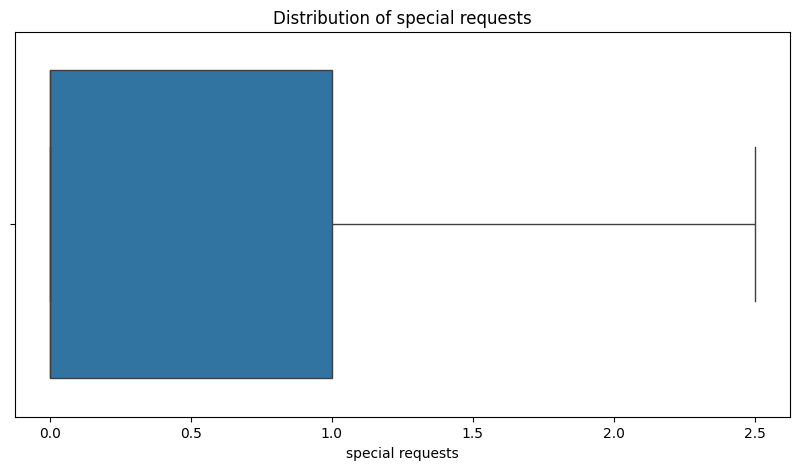

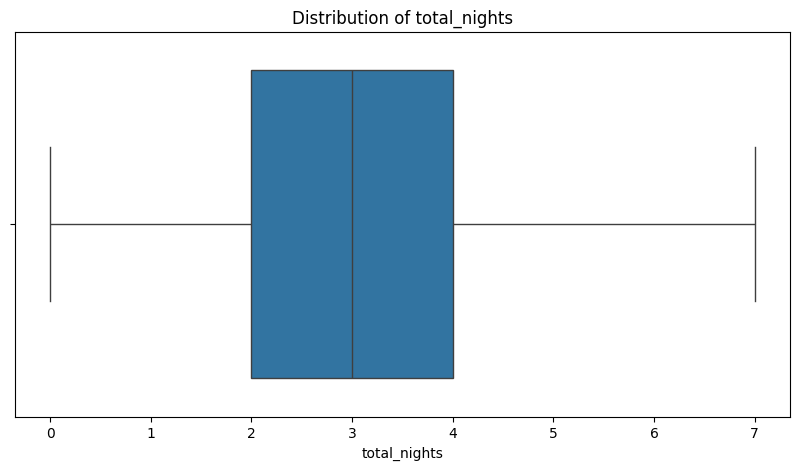

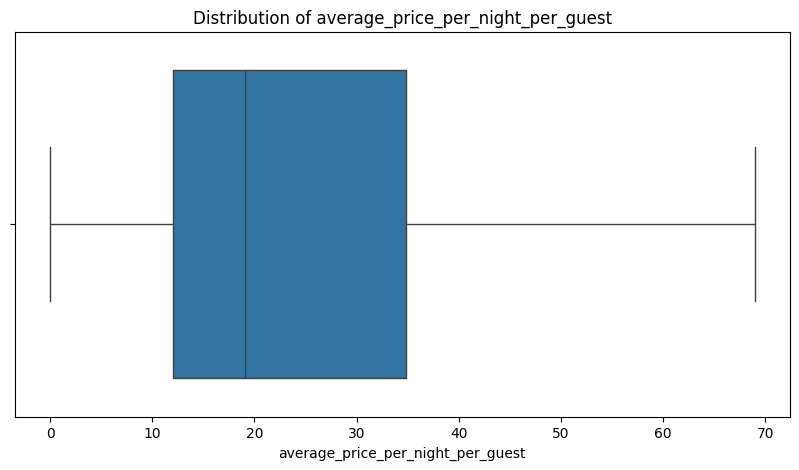

In [18]:
for feature in outlier_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df[feature])
    plt.title(f'Distribution of {feature}')
    plt.show()
    print()

## Step 4: Features Selection

In [19]:
def num_feature_selection(df: pd.DataFrame)->pd.DataFrame:
    selected_features = ['total_nights', 'average_price_per_night_per_guest',
                         'total_guest', 'lead time', 'special requests',
                         'P-C', 'P-not-C', 'repeated', 'car parking space']
    return df[selected_features]

##Step 5: Data Spliting

### Read The Data again

In [20]:
df = pd.read_csv(data_path)
df.head()

,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,date of reservation,booking status
0,INN00001,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,10/2/2015,Not_Canceled
1,INN00002,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,11/6/2018,Not_Canceled
2,INN00003,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,2/28/2018,Canceled
3,INN00004,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,5/20/2017,Canceled
4,INN00005,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,4/11/2018,Canceled


### Split Data to Target and Features

In [21]:
X, y = df.drop('booking status', axis=1), df['booking status']

### Transfrom Target to Numeric

In [22]:
target_map = {
    'Canceled': 0,
    'Not_Canceled': 1
}
y = y.map(target_map)

### Split Data to Train and Test

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((29028, 16), (7257, 16), (29028,), (7257,))

## Step 6: Design Data Pipeline

In [24]:
num_features = ['number of adults', 'number of children', 'number of weekend nights',
                'number of week nights', 'lead time', 'average price ', 'car parking space',
                'repeated', 'P-C', 'P-not-C', 'special requests']

cat_features = ['room type', 'type of meal', 'market segment type']

### Design Numeric Pipeline

In [25]:
num_pipeline = Pipeline([
    ('Features Engineering', FunctionTransformer(feature_engineering)),
    ('Outlier Treatment', FunctionTransformer(outlier_treatment, kw_args={'features_name': outlier_features})),
    ('Numerical Feature Selection', FunctionTransformer(num_feature_selection)),
    ('Imputer', SimpleImputer(strategy='median')),
    ('Scaler', StandardScaler())
])
num_pipeline

Pipeline(steps=[('Features Engineering',
                 FunctionTransformer(func=<function feature_engineering at 0x7bda4aa10700>)),
                ('Outlier Treatment',
                 FunctionTransformer(func=<function outlier_treatment at 0x7bda444d0b80>,
                                     kw_args={'features_name': ['lead time',
                                                                'special '
                                                                'requests',
                                                                'total_nights',
                                                                'average_price_per_night_per_guest']})),
                ('Numerical Feature Selection',
                 FunctionTransformer(func=<function num_feature_selection at 0x7bda4437eb00>)),
                ('Imputer', SimpleImputer(strategy='median')),
                ('Scaler', StandardScaler())])

### Design Categorical Pipeline

In [26]:
cat_pipeline = Pipeline([
    ('Imputer', SimpleImputer(strategy='most_frequent')),
    ('Encoder', OneHotEncoder(handle_unknown='ignore'))
])
cat_pipeline

Pipeline(steps=[('Imputer', SimpleImputer(strategy='most_frequent')),
                ('Encoder', OneHotEncoder(handle_unknown='ignore'))])

### Design The Full Pipeline

In [27]:
full_pipline = ColumnTransformer([
    ('Numerical Pipeline', num_pipeline, num_features),
    ('Categorical Pipeline', cat_pipeline, cat_features),
])
full_pipline

ColumnTransformer(transformers=[('Numerical Pipeline',
                                 Pipeline(steps=[('Features Engineering',
                                                  FunctionTransformer(func=<function feature_engineering at 0x7bda4aa10700>)),
                                                 ('Outlier Treatment',
                                                  FunctionTransformer(func=<function outlier_treatment at 0x7bda444d0b80>,
                                                                      kw_args={'features_name': ['lead '
                                                                                                 'time',
                                                                                                 'special '
                                                                                                 'requests',
                                                                                                 'total_nights',
                                                                                                 'average_price_per_nig...
                                 ['number of adults', 'number of children',
                                  'number of weekend nights',
                                  'number of week nights', 'lead time',
                                  'average price ', 'car parking space',
                                  'repeated', 'P-C', 'P-not-C',
                                  'special requests']),
                                ('Categorical Pipeline',
                                 Pipeline(steps=[('Imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('Encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['room type', 'type of meal',
                                  'market segment type'])])

### Transfrom The Training Data

In [28]:
X_train_transformed = full_pipline.fit_transform(X_train)
X_train_transformed.shape

(29028, 25)

## Step 7: Model Selection

### Compute Classes Weight

In [29]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train).round(2)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 1.53, 1: 0.74}

In [30]:
#optimize class weight for fast calculations
class_weights = {0: 2, 1: 1}

### Logistic Regression Classifier

In [ ]:
lg_clf = LogisticRegression(class_weight=class_weights)
cross_val_score(lg_clf, X_train_transformed, y_train, cv=5, scoring='accuracy').mean()

0.7755271433543309

### K-Neighbors Classifier

In [ ]:
knn_clf = KNeighborsClassifier(n_neighbors=10)
cross_val_score(knn_clf, X_train_transformed, y_train, cv=5, scoring='accuracy').mean()

0.8391894927075054

### SVM Classifier

In [ ]:
svm_clf = SVC(class_weight=class_weights)
cross_val_score(svm_clf, X_train_transformed, y_train, cv=5, scoring='accuracy').mean()

0.7985394775608589

### Naive Bayes Classifier

In [ ]:
nb_clf = GaussianNB()
cross_val_score(nb_clf, X_train_transformed, y_train, cv=5, scoring='accuracy').mean()

0.4086054018193185

### Decision Tree Classifier

In [ ]:
dt_clf = DecisionTreeClassifier(class_weight=class_weights)
cross_val_score(dt_clf, X_train_transformed, y_train, cv=5, scoring='accuracy').mean()

0.8396719423282162

### Random Forest Classifier

In [ ]:
rf_clf = RandomForestClassifier(class_weight=class_weights)
cross_val_score(rf_clf, X_train_transformed, y_train, cv=5, scoring='accuracy').mean()

0.868299341647522

### Hyper Pramater Tuning for Random Forest Classifier

In [37]:
rf_clf = RandomForestClassifier(random_state=42, class_weight=class_weights)
param_grid = {
    'n_estimators': [200, 100, 70, 50],
    'max_depth': [None, 10, 5, 3, 1],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4, 8],
}
grid_search = GridSearchCV(rf_clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_transformed, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight={0: 2, 1: 1},
                                              random_state=42),
             param_grid={'max_depth': [None, 10, 5, 3, 1],
                         'min_samples_leaf': [1, 2, 4, 8],
                         'min_samples_split': [2, 5],
                         'n_estimators': [200, 100, 70, 50]},
             scoring='accuracy')

In [38]:
grid_search.best_score_

0.8688506321091698

In [39]:
grid_search.best_params_

{'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

### Hyper Pramater Tuning for Decision Tree Classifier

In [40]:
rf_clf = DecisionTreeClassifier(random_state=42, class_weight=class_weights)
param_grid = {
    'max_depth': [None, 10, 5, 3, 1],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 8, 16],
}
grid_search = GridSearchCV(rf_clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_transformed, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight={0: 2, 1: 1},
                                              random_state=42),
             param_grid={'max_depth': [None, 10, 5, 3, 1],
                         'min_samples_leaf': [1, 2, 4, 8, 16],
                         'min_samples_split': [2, 5, 10, 15, 20]},
             scoring='accuracy')

In [41]:
grid_search.best_score_

0.8393273346085592

In [42]:
grid_search.best_params_

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

### Neural Networks Classifier

In [31]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_transformed.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,417 (17.25 KB)

 Trainable params: 4,417 (17.25 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
# Create custom sample weights
sample_weights = np.ones(len(y_train))
sample_weights[y_train == 0] = 2  # Assign higher weight to samples of class 0

In [34]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
hist = model.fit(X_train_transformed, y_train, epochs=100, validation_split=0.2, batch_size=32, sample_weight=sample_weights)

Epoch 1/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7521 - loss: 0.7430 - val_accuracy: 0.7852 - val_loss: 0.5900
Epoch 2/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7764 - loss: 0.6021 - val_accuracy: 0.7757 - val_loss: 0.5791
Epoch 3/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7942 - loss: 0.5828 - val_accuracy: 0.8092 - val_loss: 0.5638
Epoch 4/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7992 - loss: 0.5694 - val_accuracy: 0.8145 - val_loss: 0.5547
Epoch 5/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7975 - loss: 0.5638 - val_accuracy: 0.8179 - val_loss: 0.5498
Epoch 6/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8028 - loss: 0.5600 - val_accuracy: 0.8228 - val_loss: 0.5460
Epoch 7/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8090 - loss: 0.5491 - val_accuracy: 0.8285 - val_loss: 0.5477
Epoch 8/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8132 - loss: 0.5455 - val_accu

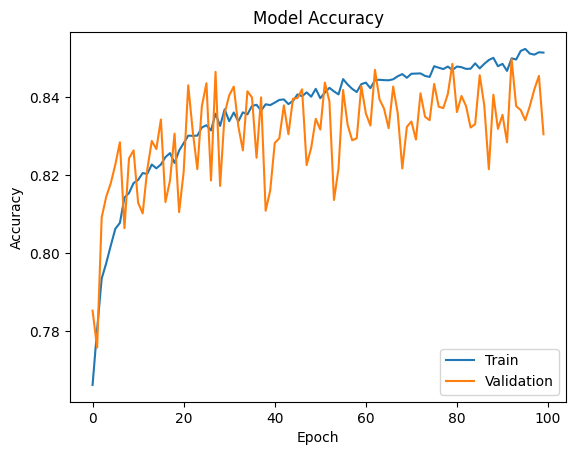

In [35]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

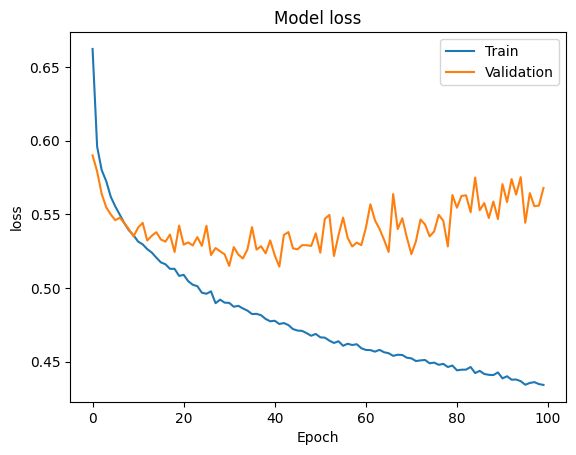

In [36]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

### Selected Modles are Decision Tree, Random Forest, and Neural Networks

## Step 8: Design The Selected Model Pipeline

### Training Data overview

In [37]:
X_train.head()

,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,date of reservation
387,INN00388,3,0,1,3,Meal Plan 1,0,Room_Type 4,155,Online,0,0,0,115.6,1,12/26/2018
7768,INN07769,1,0,2,2,Meal Plan 1,0,Room_Type 4,48,Online,0,0,0,149.4,0,9/18/2018
11792,INN11793,2,0,1,2,Meal Plan 1,0,Room_Type 1,305,Offline,0,0,0,89.0,0,11/4/2018
7978,INN07979,1,0,0,2,Meal Plan 1,0,Room_Type 1,102,Online,0,0,0,86.4,2,12/6/2018
10670,INN10671,2,2,1,2,Meal Plan 1,0,Room_Type 6,9,Online,0,0,0,221.0,0,6/10/2018


### Decision Tree

In [38]:
DT_model = Pipeline([
    ('Full Data Pipeline', full_pipline),
    ('Model', DecisionTreeClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=2, class_weight=class_weights))
])
DT_model

Pipeline(steps=[('Full Data Pipeline',
                 ColumnTransformer(transformers=[('Numerical Pipeline',
                                                  Pipeline(steps=[('Features '
                                                                   'Engineering',
                                                                   FunctionTransformer(func=<function feature_engineering at 0x7bda4aa10700>)),
                                                                  ('Outlier '
                                                                   'Treatment',
                                                                   FunctionTransformer(func=<function outlier_treatment at 0x7bda444d0b80>,
                                                                                       kw_args={'features_name': ['lead '
                                                                                                                  'time',
                                                                                                                  'special '
                                                                                                                  'request...
                                                   'lead time',
                                                   'average price ',
                                                   'car parking space',
                                                   'repeated', 'P-C', 'P-not-C',
                                                   'special requests']),
                                                 ('Categorical Pipeline',
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('Encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['room type', 'type of meal',
                                                   'market segment type'])])),
                ('Model',
                 DecisionTreeClassifier(class_weight={0: 2, 1: 1},
                                        max_depth=10))])

In [39]:
DT_model.fit(X_train, y_train)

Pipeline(steps=[('Full Data Pipeline',
                 ColumnTransformer(transformers=[('Numerical Pipeline',
                                                  Pipeline(steps=[('Features '
                                                                   'Engineering',
                                                                   FunctionTransformer(func=<function feature_engineering at 0x7bda4aa10700>)),
                                                                  ('Outlier '
                                                                   'Treatment',
                                                                   FunctionTransformer(func=<function outlier_treatment at 0x7bda444d0b80>,
                                                                                       kw_args={'features_name': ['lead '
                                                                                                                  'time',
                                                                                                                  'special '
                                                                                                                  'request...
                                                   'lead time',
                                                   'average price ',
                                                   'car parking space',
                                                   'repeated', 'P-C', 'P-not-C',
                                                   'special requests']),
                                                 ('Categorical Pipeline',
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('Encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['room type', 'type of meal',
                                                   'market segment type'])])),
                ('Model',
                 DecisionTreeClassifier(class_weight={0: 2, 1: 1},
                                        max_depth=10))])

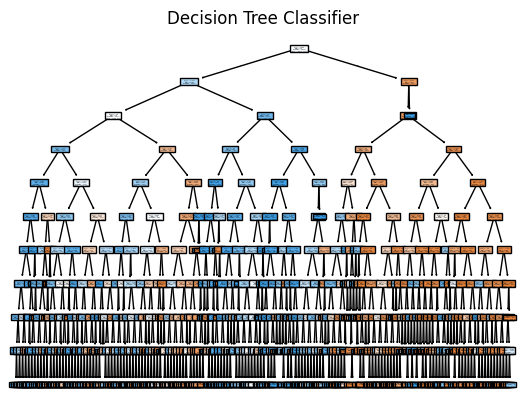

In [40]:
plot_tree(DT_model.named_steps['Model'], filled=True)
plt.title('Decision Tree Classifier')
plt.show()

In [41]:
y_pred = DT_model.predict(X_test)
dt_clf_report = classification_report(y_test, y_pred)
print(dt_clf_report)

              precision    recall  f1-score   support

           0       0.74      0.79      0.77      2402
           1       0.89      0.87      0.88      4855

    accuracy                           0.84      7257
   macro avg       0.82      0.83      0.82      7257
weighted avg       0.84      0.84      0.84      7257



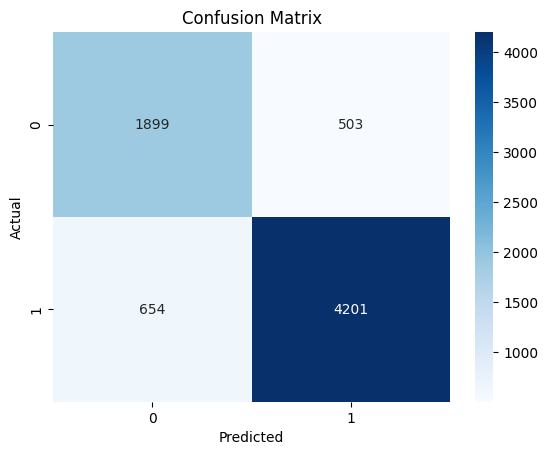

In [42]:
dt_cm = confusion_matrix(y_test, y_pred)
sns.heatmap(dt_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Random Forest

In [43]:
RF_model = Pipeline([
    ('Full Data Pipeline', full_pipline),
    ('Model', RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_leaf=2, min_samples_split=2, class_weight=class_weights))
])
RF_model

Pipeline(steps=[('Full Data Pipeline',
                 ColumnTransformer(transformers=[('Numerical Pipeline',
                                                  Pipeline(steps=[('Features '
                                                                   'Engineering',
                                                                   FunctionTransformer(func=<function feature_engineering at 0x7bda4aa10700>)),
                                                                  ('Outlier '
                                                                   'Treatment',
                                                                   FunctionTransformer(func=<function outlier_treatment at 0x7bda444d0b80>,
                                                                                       kw_args={'features_name': ['lead '
                                                                                                                  'time',
                                                                                                                  'special '
                                                                                                                  'request...
                                                   'car parking space',
                                                   'repeated', 'P-C', 'P-not-C',
                                                   'special requests']),
                                                 ('Categorical Pipeline',
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('Encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['room type', 'type of meal',
                                                   'market segment type'])])),
                ('Model',
                 RandomForestClassifier(class_weight={0: 2, 1: 1},
                                        min_samples_leaf=2,
                                        n_estimators=200))])

In [44]:
RF_model.fit(X_train, y_train)

Pipeline(steps=[('Full Data Pipeline',
                 ColumnTransformer(transformers=[('Numerical Pipeline',
                                                  Pipeline(steps=[('Features '
                                                                   'Engineering',
                                                                   FunctionTransformer(func=<function feature_engineering at 0x7bda4aa10700>)),
                                                                  ('Outlier '
                                                                   'Treatment',
                                                                   FunctionTransformer(func=<function outlier_treatment at 0x7bda444d0b80>,
                                                                                       kw_args={'features_name': ['lead '
                                                                                                                  'time',
                                                                                                                  'special '
                                                                                                                  'request...
                                                   'car parking space',
                                                   'repeated', 'P-C', 'P-not-C',
                                                   'special requests']),
                                                 ('Categorical Pipeline',
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('Encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['room type', 'type of meal',
                                                   'market segment type'])])),
                ('Model',
                 RandomForestClassifier(class_weight={0: 2, 1: 1},
                                        min_samples_leaf=2,
                                        n_estimators=200))])

In [45]:
y_pred = RF_model.predict(X_test)
rf_clf_report = classification_report(y_test, y_pred)
print(rf_clf_report)

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      2402
           1       0.91      0.91      0.91      4855

    accuracy                           0.87      7257
   macro avg       0.86      0.86      0.86      7257
weighted avg       0.87      0.87      0.87      7257



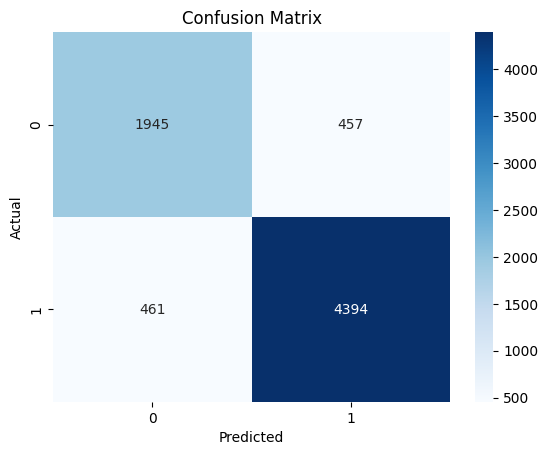

In [46]:
rf_cm = confusion_matrix(y_test, y_pred)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Neural Network Classifier

In [47]:
def create_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train_transformed.shape[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [51]:
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
keras_clf = KerasClassifier(build_fn=create_model, epochs=100, batch_size=32, verbose=1, callbacks=[early_stopping], class_weight=class_weights)

NN_model = Pipeline([
    ('Full Data Pipeline', full_pipline),
    ('Model', keras_clf)
])
NN_model

Pipeline(steps=[('Full Data Pipeline',
                 ColumnTransformer(transformers=[('Numerical Pipeline',
                                                  Pipeline(steps=[('Features '
                                                                   'Engineering',
                                                                   FunctionTransformer(func=<function feature_engineering at 0x7bda4aa10700>)),
                                                                  ('Outlier '
                                                                   'Treatment',
                                                                   FunctionTransformer(func=<function outlier_treatment at 0x7bda444d0b80>,
                                                                                       kw_args={'features_name': ['lead '
                                                                                                                  'time',
                                                                                                                  'special '
                                                                                                                  'request...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('Encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['room type', 'type of meal',
                                                   'market segment type'])])),
                ('Model',
                 KerasClassifier(batch_size=32, build_fn=<function create_model at 0x7bda44328c10>, callbacks=[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x7bda45c7f160>], class_weight={0: 2, 1: 1}, epochs=100))])

In [52]:
hist = NN_model.fit(X_train, y_train)

Epoch 1/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7257 - loss: 0.6910
Epoch 2/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7994 - loss: 0.5745
Epoch 3/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8042 - loss: 0.5662
Epoch 4/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8137 - loss: 0.5449
Epoch 5/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8138 - loss: 0.5465
Epoch 6/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8210 - loss: 0.5347
Epoch 7/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8220 - loss: 0.5305
Epoch 8/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8140 - loss: 0.5351
Epoch 9/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8226 - loss: 0.5207
Epoch 10/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8279 - loss: 0.5145
Epoch 11/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8332 - loss: 0.5054
Epoch 12/100
908/908 ━━━━━━━━━━━━━━━━━━━━

In [53]:
y_pred = NN_model.predict(X_test)
nn_clf_report = classification_report(y_test, y_pred)
print(nn_clf_report)

227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.75      0.80      0.77      2402
           1       0.90      0.87      0.88      4855

    accuracy                           0.84      7257
   macro avg       0.82      0.83      0.83      7257
weighted avg       0.85      0.84      0.85      7257



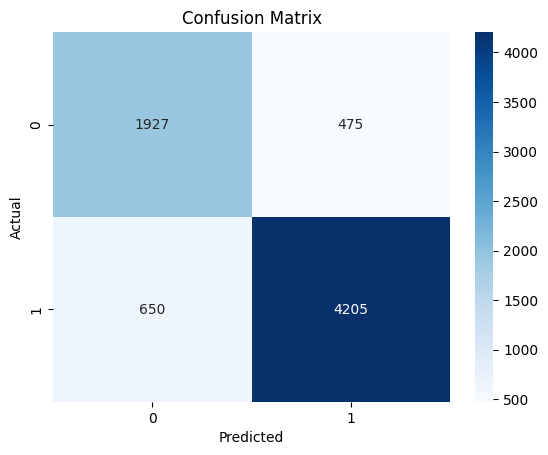

In [54]:
nn_cm = confusion_matrix(y_test, y_pred)
sns.heatmap(nn_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Compare Models Recall on Canceled Class

In [55]:
dt_recall = round(dt_cm[0][0]/(dt_cm[0][0] + dt_cm[0][1]), 2)
rf_recall = round(rf_cm[0][0]/(rf_cm[0][0] + rf_cm[0][1]), 2)
nn_recall = round(nn_cm[0][0]/(nn_cm[0][0] + nn_cm[0][1]), 2)
recalls = [dt_recall, rf_recall, nn_recall]
model_names = ['Decision Tree', 'Random Forest', 'Neural Network']
recalls

[0.79, 0.81, 0.8]

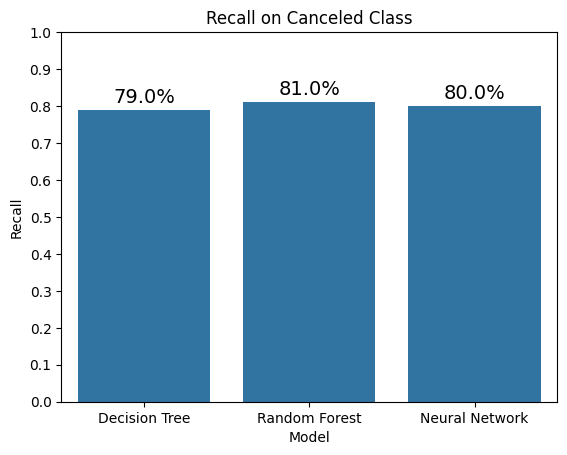

In [56]:
sns.barplot(x=model_names, y=recalls)
# Add labels for each bar
for i, recall in enumerate(recalls):
    plt.text(i, recall + 0.02, f'{recall * 100:.1f}%', ha='center', fontsize=14)
plt.title('Recall on Canceled Class')
plt.xlabel('Model')
plt.ylabel('Recall')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()